#### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# TF-Hub CORD-19 Swivel 임베딩 살펴보기


<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/hub/tutorials/cord_19_embeddings_keras"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/cord_19_embeddings_keras.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
  <td><a href="https://tfhub.dev/tensorflow/cord-19/swivel-128d/3"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델 보기</a></td>
</table>

TF-Hub(https://tfhub.dev/tensorflow/cord-19/swivel-128d/3)의 CORD-19 Swivel 텍스트 임베딩 모듈은 연구원들이 코로나바이러스감염증-19와 관련된 자연어 텍스트를 분석할 수 있도록 빌드되었습니다. 이러한 임베딩은 [CORD-19 데이터세트](https://api.semanticscholar.org/CorpusID:216056360)에 있는 기사의 제목, 저자, 요약문, 본문 텍스트 및 참조 제목에 대해 훈련되었습니다.

이 colab에서는 다음을 수행합니다.

- 임베딩 공간에서 의미론적으로 유사한 단어를 분석합니다.
- CORD-19 임베딩을 사용하여 SciCite 데이터세트에서 분류자를 훈련합니다.


## 설정


In [2]:
import functools
import itertools
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tqdm import trange

2022-12-14 20:59:19.175950: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:59:19.176062: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 20:59:19.176072: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


# 임베딩 분석하기

서로 다른 용어 간의 상관 행렬을 계산하고 플롯하여 임베딩을 분석하는 것으로 시작하겠습니다. 임베딩이 여러 단어의 의미를 성공적으로 포착하는 방법을 학습한 경우, 의미론적으로 유사한 단어의 임베딩 벡터는 서로 가까워야 합니다. 코로나바이러스감염증-19와 관련된 일부 용어를 살펴보겠습니다.

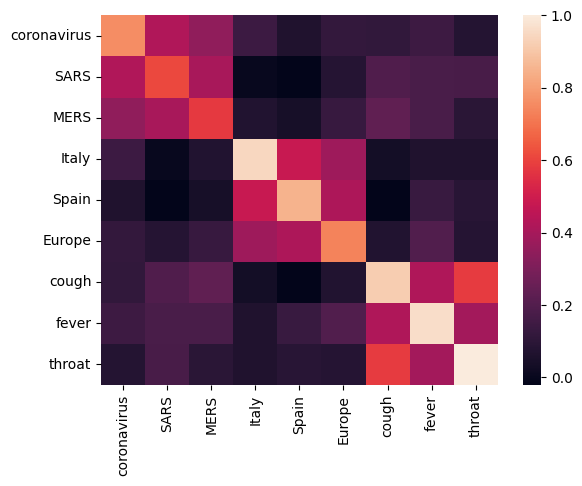

In [3]:
# Use the inner product between two embedding vectors as the similarity measure
def plot_correlation(labels, features):
  corr = np.inner(features, features)
  corr /= np.max(corr)
  sns.heatmap(corr, xticklabels=labels, yticklabels=labels)

# Generate embeddings for some terms
queries = [
  # Related viruses
  'coronavirus', 'SARS', 'MERS',
  # Regions
  'Italy', 'Spain', 'Europe',
  # Symptoms
  'cough', 'fever', 'throat'
]

module = hub.load('https://tfhub.dev/tensorflow/cord-19/swivel-128d/3')
embeddings = module(queries)

plot_correlation(queries, embeddings)

임베딩이 여러 용어의 의미를 성공적으로 포착했음을 알 수 있습니다. 각 단어는 해당 클러스터의 다른 단어와 유사하지만(즉, "coronavirus"는 "SARS" 및 "MERS"와 높은 상관 관계가 있음) 다른 클러스터의 용어와는 다릅니다(즉, "SARS"와 "Spain" 사이의 유사성은 0에 가까움).

이제 이러한 임베딩을 사용하여 특정 작업을 해결하는 방법을 살펴보겠습니다.

## SciCite: 인용 의도 분류

이 섹션에서는 텍스트 분류와 같은 다운스트림 작업에 임베딩을 사용하는 방법을 보여줍니다. TensorFlow 데이터세트의 [SciCite 데이터세트](https://www.tensorflow.org/datasets/catalog/scicite)를 사용하여 학술 논문에서 인용 의도를 분류합니다. 학술 논문의 인용이 포함된 문장이 주어지면 인용의 주요 의도가 배경 정보, 방법 사용 또는 결과 비교인지 여부를 분류합니다.

In [4]:
builder = tfds.builder(name='scicite')
builder.download_and_prepare()
train_data, validation_data, test_data = builder.as_dataset(
    split=('train', 'validation', 'test'),
    as_supervised=True)

In [5]:
#@title Let's take a look at a few labeled examples from the training set
NUM_EXAMPLES =   10#@param {type:"integer"}

TEXT_FEATURE_NAME = builder.info.supervised_keys[0]
LABEL_NAME = builder.info.supervised_keys[1]

def label2str(numeric_label):
  m = builder.info.features[LABEL_NAME].names
  return m[numeric_label]

data = next(iter(train_data.batch(NUM_EXAMPLES)))


pd.DataFrame({
    TEXT_FEATURE_NAME: [ex.numpy().decode('utf8') for ex in data[0]],
    LABEL_NAME: [label2str(x) for x in data[1]]
})

string       label
0  The finding that BMI is closely related to TBF...      result
1  The average magnitude of the NBR increases wit...  background
2  It has been reported that NF-κB activation can...      result
3  , 2008; Quraan and Cheyne, 2008; Quraan and Ch...  background
4  5B), but, interestingly, they shared conserved...  background
5  Some investigators have noted an association o...  background
6  In our previous study, it is documented that b...  background
7  These subjects have intact cognitive function ...  background
8  Another study reported improved knee function ...  background
9  C. Data Analysis Transcription Speech samples ...      method

## 인용 의도 분류자 훈련하기

Keras를 사용하여 [SciCite 데이터세트](https://www.tensorflow.org/datasets/catalog/scicite)에 대한 분류자를 훈련합니다. 분류 레이어를 상위에 둔 CORD-19 임베딩을 사용하는 모델을 빌드하겠습니다.

In [6]:
#@title Hyperparameters { run: "auto" }

EMBEDDING = 'https://tfhub.dev/tensorflow/cord-19/swivel-128d/3'  #@param {type: "string"}
TRAINABLE_MODULE = False  #@param {type: "boolean"}

hub_layer = hub.KerasLayer(EMBEDDING, input_shape=[], 
                           dtype=tf.string, trainable=TRAINABLE_MODULE)

model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(3))
model.summary()
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 keras_layer (KerasLayer)    (None, 128)               17301632  


 dense (Dense)               (None, 3)                 387       


Total params: 17,302,019


Trainable params: 387


Non-trainable params: 17,301,632


_________________________________________________________________


## 모델 훈련 및 평가하기

SciCite 작업의 성능을 확인하기 위해 모델을 훈련하고 평가하겠습니다.

In [7]:
EPOCHS = 35#@param {type: "integer"}
BATCH_SIZE = 32#@param {type: "integer"}

history = model.fit(train_data.shuffle(10000).batch(BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=validation_data.batch(BATCH_SIZE),
                    verbose=1)

Epoch 1/35


  1/257 [..............................] - ETA: 5:42 - loss: 1.0626 - accuracy: 0.4375

 15/257 [>.............................] - ETA: 0s - loss: 1.0819 - accuracy: 0.4646  

 29/257 [==>...........................] - ETA: 0s - loss: 1.0468 - accuracy: 0.5097

 44/257 [====>.........................] - ETA: 0s - loss: 1.0147 - accuracy: 0.5327

 59/257 [=====>........................] - ETA: 0s - loss: 1.0106 - accuracy: 0.5328

 74/257 [=======>......................] - ETA: 0s - loss: 0.9930 - accuracy: 0.5465

 89/257 [=========>....................] - ETA: 0s - loss: 0.9688 - accuracy: 0.5558

104/257 [===========>..................] - ETA: 0s - loss: 0.9541 - accuracy: 0.5658

119/257 [============>.................] - ETA: 0s - loss: 0.9430 - accuracy: 0.5762

134/257 [==============>...............] - ETA: 0s - loss: 0.9337 - accuracy: 0.5870

149/257 [================>.............] - ETA: 0s - loss: 0.9201 - accuracy: 0.5975

165/257 [==================>...........] - ETA: 0s - loss: 0.9090 - accuracy: 0.6078

181/257 [====================>.........] - ETA: 0s - loss: 0.8975 - accuracy: 0.6155

197/257 [=====================>........] - ETA: 0s - loss: 0.8905 - accuracy: 0.6201

213/257 [=======================>......] - ETA: 0s - loss: 0.8852 - accuracy: 0.6228

229/257 [=========================>....] - ETA: 0s - loss: 0.8790 - accuracy: 0.6264

244/257 [===========================>..] - ETA: 0s - loss: 0.8711 - accuracy: 0.6304

257/257 [==============================] - 3s 5ms/step - loss: 0.8662 - accuracy: 0.6333 - val_loss: 0.7538 - val_accuracy: 0.6932


Epoch 2/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.7042 - accuracy: 0.6875

 16/257 [>.............................] - ETA: 0s - loss: 0.7690 - accuracy: 0.6719  

 31/257 [==>...........................] - ETA: 0s - loss: 0.7433 - accuracy: 0.6885

 46/257 [====>.........................] - ETA: 0s - loss: 0.7320 - accuracy: 0.6990

 61/257 [======>.......................] - ETA: 0s - loss: 0.7166 - accuracy: 0.7100

 76/257 [=======>......................] - ETA: 0s - loss: 0.7094 - accuracy: 0.7159

 91/257 [=========>....................] - ETA: 0s - loss: 0.7025 - accuracy: 0.7201

107/257 [===========>..................] - ETA: 0s - loss: 0.6959 - accuracy: 0.7243

123/257 [=============>................] - ETA: 0s - loss: 0.6944 - accuracy: 0.7241

139/257 [===============>..............] - ETA: 0s - loss: 0.6973 - accuracy: 0.7221

154/257 [================>.............] - ETA: 0s - loss: 0.6943 - accuracy: 0.7240

170/257 [==================>...........] - ETA: 0s - loss: 0.6904 - accuracy: 0.7276

185/257 [====================>.........] - ETA: 0s - loss: 0.6891 - accuracy: 0.7277

200/257 [======================>.......] - ETA: 0s - loss: 0.6873 - accuracy: 0.7277

215/257 [========================>.....] - ETA: 0s - loss: 0.6868 - accuracy: 0.7272

230/257 [=========================>....] - ETA: 0s - loss: 0.6848 - accuracy: 0.7270

245/257 [===========================>..] - ETA: 0s - loss: 0.6831 - accuracy: 0.7272

257/257 [==============================] - 1s 4ms/step - loss: 0.6827 - accuracy: 0.7269 - val_loss: 0.6606 - val_accuracy: 0.7555


Epoch 3/35


  1/257 [..............................] - ETA: 1:19 - loss: 0.7826 - accuracy: 0.7188

 16/257 [>.............................] - ETA: 0s - loss: 0.6188 - accuracy: 0.7656  

 31/257 [==>...........................] - ETA: 0s - loss: 0.6215 - accuracy: 0.7641

 46/257 [====>.........................] - ETA: 0s - loss: 0.6254 - accuracy: 0.7575

 61/257 [======>.......................] - ETA: 0s - loss: 0.6317 - accuracy: 0.7526

 77/257 [=======>......................] - ETA: 0s - loss: 0.6300 - accuracy: 0.7561

 93/257 [=========>....................] - ETA: 0s - loss: 0.6321 - accuracy: 0.7527

109/257 [===========>..................] - ETA: 0s - loss: 0.6308 - accuracy: 0.7546

124/257 [=============>................] - ETA: 0s - loss: 0.6282 - accuracy: 0.7573

139/257 [===============>..............] - ETA: 0s - loss: 0.6259 - accuracy: 0.7594

154/257 [================>.............] - ETA: 0s - loss: 0.6296 - accuracy: 0.7555

169/257 [==================>...........] - ETA: 0s - loss: 0.6263 - accuracy: 0.7568

184/257 [====================>.........] - ETA: 0s - loss: 0.6245 - accuracy: 0.7573

199/257 [======================>.......] - ETA: 0s - loss: 0.6263 - accuracy: 0.7564

215/257 [========================>.....] - ETA: 0s - loss: 0.6225 - accuracy: 0.7593

230/257 [=========================>....] - ETA: 0s - loss: 0.6215 - accuracy: 0.7584

245/257 [===========================>..] - ETA: 0s - loss: 0.6170 - accuracy: 0.7608

257/257 [==============================] - 1s 4ms/step - loss: 0.6159 - accuracy: 0.7617 - val_loss: 0.6189 - val_accuracy: 0.7598


Epoch 4/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.6842 - accuracy: 0.6562

 16/257 [>.............................] - ETA: 0s - loss: 0.6086 - accuracy: 0.7715  

 32/257 [==>...........................] - ETA: 0s - loss: 0.6106 - accuracy: 0.7666

 48/257 [====>.........................] - ETA: 0s - loss: 0.6005 - accuracy: 0.7773

 64/257 [======>.......................] - ETA: 0s - loss: 0.5960 - accuracy: 0.7754

 79/257 [========>.....................] - ETA: 0s - loss: 0.5943 - accuracy: 0.7718

 94/257 [=========>....................] - ETA: 0s - loss: 0.5995 - accuracy: 0.7670

110/257 [===========>..................] - ETA: 0s - loss: 0.6012 - accuracy: 0.7642

126/257 [=============>................] - ETA: 0s - loss: 0.5980 - accuracy: 0.7693

142/257 [===============>..............] - ETA: 0s - loss: 0.5980 - accuracy: 0.7687

158/257 [=================>............] - ETA: 0s - loss: 0.5957 - accuracy: 0.7696

173/257 [===================>..........] - ETA: 0s - loss: 0.5968 - accuracy: 0.7673

188/257 [====================>.........] - ETA: 0s - loss: 0.5963 - accuracy: 0.7665

203/257 [======================>.......] - ETA: 0s - loss: 0.5950 - accuracy: 0.7665

219/257 [========================>.....] - ETA: 0s - loss: 0.5926 - accuracy: 0.7678

235/257 [==========================>...] - ETA: 0s - loss: 0.5906 - accuracy: 0.7678

251/257 [============================>.] - ETA: 0s - loss: 0.5854 - accuracy: 0.7698

257/257 [==============================] - 1s 4ms/step - loss: 0.5836 - accuracy: 0.7711 - val_loss: 0.5991 - val_accuracy: 0.7697


Epoch 5/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.4727 - accuracy: 0.9062

 16/257 [>.............................] - ETA: 0s - loss: 0.5514 - accuracy: 0.7910  

 30/257 [==>...........................] - ETA: 0s - loss: 0.5636 - accuracy: 0.7844

 45/257 [====>.........................] - ETA: 0s - loss: 0.5685 - accuracy: 0.7812

 60/257 [======>.......................] - ETA: 0s - loss: 0.5697 - accuracy: 0.7776

 75/257 [=======>......................] - ETA: 0s - loss: 0.5705 - accuracy: 0.7788

 90/257 [=========>....................] - ETA: 0s - loss: 0.5701 - accuracy: 0.7809

105/257 [===========>..................] - ETA: 0s - loss: 0.5696 - accuracy: 0.7795

120/257 [=============>................] - ETA: 0s - loss: 0.5731 - accuracy: 0.7773

134/257 [==============>...............] - ETA: 0s - loss: 0.5722 - accuracy: 0.7789

149/257 [================>.............] - ETA: 0s - loss: 0.5753 - accuracy: 0.7787

164/257 [==================>...........] - ETA: 0s - loss: 0.5718 - accuracy: 0.7784

179/257 [===================>..........] - ETA: 0s - loss: 0.5687 - accuracy: 0.7811

194/257 [=====================>........] - ETA: 0s - loss: 0.5676 - accuracy: 0.7806

209/257 [=======================>......] - ETA: 0s - loss: 0.5672 - accuracy: 0.7796

224/257 [=========================>....] - ETA: 0s - loss: 0.5656 - accuracy: 0.7807

239/257 [==========================>...] - ETA: 0s - loss: 0.5659 - accuracy: 0.7801

254/257 [============================>.] - ETA: 0s - loss: 0.5649 - accuracy: 0.7805

257/257 [==============================] - 1s 5ms/step - loss: 0.5653 - accuracy: 0.7801 - val_loss: 0.5868 - val_accuracy: 0.7664


Epoch 6/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.5769 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.5974 - accuracy: 0.7676  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5793 - accuracy: 0.7843

 47/257 [====>.........................] - ETA: 0s - loss: 0.5760 - accuracy: 0.7773

 63/257 [======>.......................] - ETA: 0s - loss: 0.5731 - accuracy: 0.7778

 78/257 [========>.....................] - ETA: 0s - loss: 0.5647 - accuracy: 0.7804

 93/257 [=========>....................] - ETA: 0s - loss: 0.5678 - accuracy: 0.7752

108/257 [===========>..................] - ETA: 0s - loss: 0.5670 - accuracy: 0.7746

124/257 [=============>................] - ETA: 0s - loss: 0.5655 - accuracy: 0.7777

139/257 [===============>..............] - ETA: 0s - loss: 0.5616 - accuracy: 0.7795

155/257 [=================>............] - ETA: 0s - loss: 0.5595 - accuracy: 0.7800

171/257 [==================>...........] - ETA: 0s - loss: 0.5608 - accuracy: 0.7781

186/257 [====================>.........] - ETA: 0s - loss: 0.5568 - accuracy: 0.7819

201/257 [======================>.......] - ETA: 0s - loss: 0.5535 - accuracy: 0.7844

217/257 [========================>.....] - ETA: 0s - loss: 0.5537 - accuracy: 0.7838

232/257 [==========================>...] - ETA: 0s - loss: 0.5532 - accuracy: 0.7835

247/257 [===========================>..] - ETA: 0s - loss: 0.5534 - accuracy: 0.7842

257/257 [==============================] - 1s 4ms/step - loss: 0.5535 - accuracy: 0.7841 - val_loss: 0.5771 - val_accuracy: 0.7686


Epoch 7/35


  1/257 [..............................] - ETA: 1:27 - loss: 0.4585 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5404 - accuracy: 0.7734  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5593 - accuracy: 0.7802

 46/257 [====>.........................] - ETA: 0s - loss: 0.5550 - accuracy: 0.7826

 60/257 [======>.......................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7901

 75/257 [=======>......................] - ETA: 0s - loss: 0.5536 - accuracy: 0.7858

 89/257 [=========>....................] - ETA: 0s - loss: 0.5568 - accuracy: 0.7834

104/257 [===========>..................] - ETA: 0s - loss: 0.5580 - accuracy: 0.7819

120/257 [=============>................] - ETA: 0s - loss: 0.5531 - accuracy: 0.7857

136/257 [==============>...............] - ETA: 0s - loss: 0.5487 - accuracy: 0.7881

151/257 [================>.............] - ETA: 0s - loss: 0.5535 - accuracy: 0.7858

167/257 [==================>...........] - ETA: 0s - loss: 0.5465 - accuracy: 0.7880

182/257 [====================>.........] - ETA: 0s - loss: 0.5456 - accuracy: 0.7886

198/257 [======================>.......] - ETA: 0s - loss: 0.5448 - accuracy: 0.7884

213/257 [=======================>......] - ETA: 0s - loss: 0.5456 - accuracy: 0.7876

228/257 [=========================>....] - ETA: 0s - loss: 0.5446 - accuracy: 0.7882

243/257 [===========================>..] - ETA: 0s - loss: 0.5439 - accuracy: 0.7885

257/257 [==============================] - 1s 4ms/step - loss: 0.5449 - accuracy: 0.7884 - val_loss: 0.5719 - val_accuracy: 0.7729


Epoch 8/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.4849 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.5330 - accuracy: 0.7930  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5425 - accuracy: 0.7930

 48/257 [====>.........................] - ETA: 0s - loss: 0.5341 - accuracy: 0.8001

 64/257 [======>.......................] - ETA: 0s - loss: 0.5407 - accuracy: 0.7925

 80/257 [========>.....................] - ETA: 0s - loss: 0.5429 - accuracy: 0.7934

 95/257 [==========>...................] - ETA: 0s - loss: 0.5427 - accuracy: 0.7924

110/257 [===========>..................] - ETA: 0s - loss: 0.5398 - accuracy: 0.7926

125/257 [=============>................] - ETA: 0s - loss: 0.5437 - accuracy: 0.7900

140/257 [===============>..............] - ETA: 0s - loss: 0.5381 - accuracy: 0.7922

155/257 [=================>............] - ETA: 0s - loss: 0.5446 - accuracy: 0.7883

171/257 [==================>...........] - ETA: 0s - loss: 0.5418 - accuracy: 0.7898

187/257 [====================>.........] - ETA: 0s - loss: 0.5393 - accuracy: 0.7903

202/257 [======================>.......] - ETA: 0s - loss: 0.5362 - accuracy: 0.7913

217/257 [========================>.....] - ETA: 0s - loss: 0.5353 - accuracy: 0.7910

232/257 [==========================>...] - ETA: 0s - loss: 0.5347 - accuracy: 0.7922

247/257 [===========================>..] - ETA: 0s - loss: 0.5367 - accuracy: 0.7921

257/257 [==============================] - 1s 4ms/step - loss: 0.5385 - accuracy: 0.7913 - val_loss: 0.5677 - val_accuracy: 0.7751


Epoch 9/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.4688 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5593 - accuracy: 0.7754  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5634 - accuracy: 0.7732

 46/257 [====>.........................] - ETA: 0s - loss: 0.5448 - accuracy: 0.7846

 61/257 [======>.......................] - ETA: 0s - loss: 0.5459 - accuracy: 0.7818

 76/257 [=======>......................] - ETA: 0s - loss: 0.5390 - accuracy: 0.7829

 91/257 [=========>....................] - ETA: 0s - loss: 0.5416 - accuracy: 0.7850

107/257 [===========>..................] - ETA: 0s - loss: 0.5407 - accuracy: 0.7871

123/257 [=============>................] - ETA: 0s - loss: 0.5428 - accuracy: 0.7856

139/257 [===============>..............] - ETA: 0s - loss: 0.5394 - accuracy: 0.7880

155/257 [=================>............] - ETA: 0s - loss: 0.5378 - accuracy: 0.7899

171/257 [==================>...........] - ETA: 0s - loss: 0.5392 - accuracy: 0.7908

186/257 [====================>.........] - ETA: 0s - loss: 0.5381 - accuracy: 0.7907

201/257 [======================>.......] - ETA: 0s - loss: 0.5385 - accuracy: 0.7914

216/257 [========================>.....] - ETA: 0s - loss: 0.5360 - accuracy: 0.7927

231/257 [=========================>....] - ETA: 0s - loss: 0.5349 - accuracy: 0.7922

246/257 [===========================>..] - ETA: 0s - loss: 0.5348 - accuracy: 0.7917

257/257 [==============================] - 1s 4ms/step - loss: 0.5335 - accuracy: 0.7919 - val_loss: 0.5627 - val_accuracy: 0.7729


Epoch 10/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.9383 - accuracy: 0.5938

 15/257 [>.............................] - ETA: 0s - loss: 0.6247 - accuracy: 0.7542  

 30/257 [==>...........................] - ETA: 0s - loss: 0.5566 - accuracy: 0.7833

 45/257 [====>.........................] - ETA: 0s - loss: 0.5481 - accuracy: 0.7819

 60/257 [======>.......................] - ETA: 0s - loss: 0.5421 - accuracy: 0.7865

 75/257 [=======>......................] - ETA: 0s - loss: 0.5339 - accuracy: 0.7904

 90/257 [=========>....................] - ETA: 0s - loss: 0.5286 - accuracy: 0.7965

105/257 [===========>..................] - ETA: 0s - loss: 0.5200 - accuracy: 0.7982

120/257 [=============>................] - ETA: 0s - loss: 0.5269 - accuracy: 0.7948

135/257 [==============>...............] - ETA: 0s - loss: 0.5252 - accuracy: 0.7942

151/257 [================>.............] - ETA: 0s - loss: 0.5287 - accuracy: 0.7914

166/257 [==================>...........] - ETA: 0s - loss: 0.5288 - accuracy: 0.7929

181/257 [====================>.........] - ETA: 0s - loss: 0.5299 - accuracy: 0.7933

196/257 [=====================>........] - ETA: 0s - loss: 0.5281 - accuracy: 0.7943

211/257 [=======================>......] - ETA: 0s - loss: 0.5292 - accuracy: 0.7941

226/257 [=========================>....] - ETA: 0s - loss: 0.5295 - accuracy: 0.7940

242/257 [===========================>..] - ETA: 0s - loss: 0.5319 - accuracy: 0.7930

257/257 [==============================] - 1s 4ms/step - loss: 0.5285 - accuracy: 0.7940 - val_loss: 0.5611 - val_accuracy: 0.7707


Epoch 11/35


  1/257 [..............................] - ETA: 1:17 - loss: 0.6022 - accuracy: 0.7188

 16/257 [>.............................] - ETA: 0s - loss: 0.5276 - accuracy: 0.7891  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5330 - accuracy: 0.7833

 46/257 [====>.........................] - ETA: 0s - loss: 0.5226 - accuracy: 0.7880

 61/257 [======>.......................] - ETA: 0s - loss: 0.5220 - accuracy: 0.7976

 76/257 [=======>......................] - ETA: 0s - loss: 0.5219 - accuracy: 0.7948

 91/257 [=========>....................] - ETA: 0s - loss: 0.5267 - accuracy: 0.7936

106/257 [===========>..................] - ETA: 0s - loss: 0.5262 - accuracy: 0.7927

122/257 [=============>................] - ETA: 0s - loss: 0.5222 - accuracy: 0.7938

137/257 [==============>...............] - ETA: 0s - loss: 0.5243 - accuracy: 0.7922

153/257 [================>.............] - ETA: 0s - loss: 0.5284 - accuracy: 0.7933

168/257 [==================>...........] - ETA: 0s - loss: 0.5314 - accuracy: 0.7920

184/257 [====================>.........] - ETA: 0s - loss: 0.5293 - accuracy: 0.7931

199/257 [======================>.......] - ETA: 0s - loss: 0.5295 - accuracy: 0.7927

215/257 [========================>.....] - ETA: 0s - loss: 0.5279 - accuracy: 0.7936

231/257 [=========================>....] - ETA: 0s - loss: 0.5234 - accuracy: 0.7961

246/257 [===========================>..] - ETA: 0s - loss: 0.5208 - accuracy: 0.7980

257/257 [==============================] - 1s 4ms/step - loss: 0.5253 - accuracy: 0.7958 - val_loss: 0.5574 - val_accuracy: 0.7751


Epoch 12/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.4547 - accuracy: 0.8438

 15/257 [>.............................] - ETA: 0s - loss: 0.4556 - accuracy: 0.8208  

 30/257 [==>...........................] - ETA: 0s - loss: 0.4673 - accuracy: 0.8115

 45/257 [====>.........................] - ETA: 0s - loss: 0.4803 - accuracy: 0.8069

 60/257 [======>.......................] - ETA: 0s - loss: 0.4971 - accuracy: 0.8000

 75/257 [=======>......................] - ETA: 0s - loss: 0.5058 - accuracy: 0.7975

 90/257 [=========>....................] - ETA: 0s - loss: 0.5130 - accuracy: 0.7924

105/257 [===========>..................] - ETA: 0s - loss: 0.5186 - accuracy: 0.7920

120/257 [=============>................] - ETA: 0s - loss: 0.5167 - accuracy: 0.7948

135/257 [==============>...............] - ETA: 0s - loss: 0.5131 - accuracy: 0.7986

150/257 [================>.............] - ETA: 0s - loss: 0.5204 - accuracy: 0.7950

165/257 [==================>...........] - ETA: 0s - loss: 0.5220 - accuracy: 0.7934

180/257 [====================>.........] - ETA: 0s - loss: 0.5243 - accuracy: 0.7939

196/257 [=====================>........] - ETA: 0s - loss: 0.5196 - accuracy: 0.7959

212/257 [=======================>......] - ETA: 0s - loss: 0.5218 - accuracy: 0.7933

227/257 [=========================>....] - ETA: 0s - loss: 0.5208 - accuracy: 0.7941

242/257 [===========================>..] - ETA: 0s - loss: 0.5216 - accuracy: 0.7943

257/257 [==============================] - ETA: 0s - loss: 0.5222 - accuracy: 0.7933

257/257 [==============================] - 2s 5ms/step - loss: 0.5222 - accuracy: 0.7933 - val_loss: 0.5539 - val_accuracy: 0.7751


Epoch 13/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.4435 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5050 - accuracy: 0.7930  

 32/257 [==>...........................] - ETA: 0s - loss: 0.5003 - accuracy: 0.7979

 48/257 [====>.........................] - ETA: 0s - loss: 0.5141 - accuracy: 0.7982

 64/257 [======>.......................] - ETA: 0s - loss: 0.5216 - accuracy: 0.7949

 80/257 [========>.....................] - ETA: 0s - loss: 0.5175 - accuracy: 0.7957

 96/257 [==========>...................] - ETA: 0s - loss: 0.5241 - accuracy: 0.7939

112/257 [============>.................] - ETA: 0s - loss: 0.5297 - accuracy: 0.7902

128/257 [=============>................] - ETA: 0s - loss: 0.5206 - accuracy: 0.7947

144/257 [===============>..............] - ETA: 0s - loss: 0.5201 - accuracy: 0.7943

159/257 [=================>............] - ETA: 0s - loss: 0.5212 - accuracy: 0.7932

174/257 [===================>..........] - ETA: 0s - loss: 0.5207 - accuracy: 0.7945

189/257 [=====================>........] - ETA: 0s - loss: 0.5227 - accuracy: 0.7933

204/257 [======================>.......] - ETA: 0s - loss: 0.5182 - accuracy: 0.7952

219/257 [========================>.....] - ETA: 0s - loss: 0.5181 - accuracy: 0.7954

235/257 [==========================>...] - ETA: 0s - loss: 0.5171 - accuracy: 0.7955

250/257 [============================>.] - ETA: 0s - loss: 0.5191 - accuracy: 0.7939

257/257 [==============================] - 1s 4ms/step - loss: 0.5201 - accuracy: 0.7941 - val_loss: 0.5523 - val_accuracy: 0.7762


Epoch 14/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.5465 - accuracy: 0.7812

 16/257 [>.............................] - ETA: 0s - loss: 0.4927 - accuracy: 0.8086  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4939 - accuracy: 0.8105

 47/257 [====>.........................] - ETA: 0s - loss: 0.5127 - accuracy: 0.8032

 63/257 [======>.......................] - ETA: 0s - loss: 0.5180 - accuracy: 0.7991

 79/257 [========>.....................] - ETA: 0s - loss: 0.5148 - accuracy: 0.8034

 94/257 [=========>....................] - ETA: 0s - loss: 0.5073 - accuracy: 0.8075

109/257 [===========>..................] - ETA: 0s - loss: 0.5164 - accuracy: 0.8028

125/257 [=============>................] - ETA: 0s - loss: 0.5163 - accuracy: 0.8012

141/257 [===============>..............] - ETA: 0s - loss: 0.5211 - accuracy: 0.7985

156/257 [=================>............] - ETA: 0s - loss: 0.5262 - accuracy: 0.7957

172/257 [===================>..........] - ETA: 0s - loss: 0.5243 - accuracy: 0.7956

188/257 [====================>.........] - ETA: 0s - loss: 0.5245 - accuracy: 0.7940

203/257 [======================>.......] - ETA: 0s - loss: 0.5209 - accuracy: 0.7948

218/257 [========================>.....] - ETA: 0s - loss: 0.5198 - accuracy: 0.7954

233/257 [==========================>...] - ETA: 0s - loss: 0.5189 - accuracy: 0.7948

248/257 [===========================>..] - ETA: 0s - loss: 0.5188 - accuracy: 0.7945

257/257 [==============================] - 1s 4ms/step - loss: 0.5179 - accuracy: 0.7951 - val_loss: 0.5518 - val_accuracy: 0.7762


Epoch 15/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.7121 - accuracy: 0.5938

 16/257 [>.............................] - ETA: 0s - loss: 0.5226 - accuracy: 0.7910  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5150 - accuracy: 0.7903

 46/257 [====>.........................] - ETA: 0s - loss: 0.5021 - accuracy: 0.7996

 61/257 [======>.......................] - ETA: 0s - loss: 0.5064 - accuracy: 0.8017

 76/257 [=======>......................] - ETA: 0s - loss: 0.5059 - accuracy: 0.8002

 90/257 [=========>....................] - ETA: 0s - loss: 0.5038 - accuracy: 0.8014

105/257 [===========>..................] - ETA: 0s - loss: 0.5043 - accuracy: 0.8012

119/257 [============>.................] - ETA: 0s - loss: 0.5028 - accuracy: 0.8012

134/257 [==============>...............] - ETA: 0s - loss: 0.4995 - accuracy: 0.8022

149/257 [================>.............] - ETA: 0s - loss: 0.5021 - accuracy: 0.8018

164/257 [==================>...........] - ETA: 0s - loss: 0.5064 - accuracy: 0.8013

179/257 [===================>..........] - ETA: 0s - loss: 0.5058 - accuracy: 0.8013

194/257 [=====================>........] - ETA: 0s - loss: 0.5072 - accuracy: 0.7999

209/257 [=======================>......] - ETA: 0s - loss: 0.5071 - accuracy: 0.7998

225/257 [=========================>....] - ETA: 0s - loss: 0.5107 - accuracy: 0.7975

240/257 [===========================>..] - ETA: 0s - loss: 0.5141 - accuracy: 0.7957

255/257 [============================>.] - ETA: 0s - loss: 0.5139 - accuracy: 0.7967

257/257 [==============================] - 2s 5ms/step - loss: 0.5154 - accuracy: 0.7959 - val_loss: 0.5496 - val_accuracy: 0.7795


Epoch 16/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.5535 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.5601 - accuracy: 0.7695  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5491 - accuracy: 0.7833

 46/257 [====>.........................] - ETA: 0s - loss: 0.5508 - accuracy: 0.7853

 61/257 [======>.......................] - ETA: 0s - loss: 0.5382 - accuracy: 0.7889

 76/257 [=======>......................] - ETA: 0s - loss: 0.5314 - accuracy: 0.7899

 92/257 [=========>....................] - ETA: 0s - loss: 0.5340 - accuracy: 0.7891

107/257 [===========>..................] - ETA: 0s - loss: 0.5331 - accuracy: 0.7891

122/257 [=============>................] - ETA: 0s - loss: 0.5273 - accuracy: 0.7920

137/257 [==============>...............] - ETA: 0s - loss: 0.5230 - accuracy: 0.7929

152/257 [================>.............] - ETA: 0s - loss: 0.5190 - accuracy: 0.7958

167/257 [==================>...........] - ETA: 0s - loss: 0.5167 - accuracy: 0.7972

182/257 [====================>.........] - ETA: 0s - loss: 0.5148 - accuracy: 0.7965

198/257 [======================>.......] - ETA: 0s - loss: 0.5134 - accuracy: 0.7988

214/257 [=======================>......] - ETA: 0s - loss: 0.5118 - accuracy: 0.7986

229/257 [=========================>....] - ETA: 0s - loss: 0.5094 - accuracy: 0.7990

244/257 [===========================>..] - ETA: 0s - loss: 0.5107 - accuracy: 0.7985

257/257 [==============================] - 1s 4ms/step - loss: 0.5138 - accuracy: 0.7975 - val_loss: 0.5517 - val_accuracy: 0.7784


Epoch 17/35


  1/257 [..............................] - ETA: 1:34 - loss: 0.5751 - accuracy: 0.7500

 16/257 [>.............................] - ETA: 0s - loss: 0.5322 - accuracy: 0.7949  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7833

 46/257 [====>.........................] - ETA: 0s - loss: 0.5403 - accuracy: 0.7840

 61/257 [======>.......................] - ETA: 0s - loss: 0.5447 - accuracy: 0.7797

 76/257 [=======>......................] - ETA: 0s - loss: 0.5369 - accuracy: 0.7866

 91/257 [=========>....................] - ETA: 0s - loss: 0.5292 - accuracy: 0.7878

106/257 [===========>..................] - ETA: 0s - loss: 0.5280 - accuracy: 0.7889

122/257 [=============>................] - ETA: 0s - loss: 0.5263 - accuracy: 0.7889

137/257 [==============>...............] - ETA: 0s - loss: 0.5235 - accuracy: 0.7911

152/257 [================>.............] - ETA: 0s - loss: 0.5201 - accuracy: 0.7921

167/257 [==================>...........] - ETA: 0s - loss: 0.5190 - accuracy: 0.7938

182/257 [====================>.........] - ETA: 0s - loss: 0.5174 - accuracy: 0.7950

197/257 [=====================>........] - ETA: 0s - loss: 0.5184 - accuracy: 0.7947

212/257 [=======================>......] - ETA: 0s - loss: 0.5151 - accuracy: 0.7963

227/257 [=========================>....] - ETA: 0s - loss: 0.5169 - accuracy: 0.7956

242/257 [===========================>..] - ETA: 0s - loss: 0.5147 - accuracy: 0.7962

257/257 [==============================] - ETA: 0s - loss: 0.5119 - accuracy: 0.7977

257/257 [==============================] - 2s 4ms/step - loss: 0.5119 - accuracy: 0.7977 - val_loss: 0.5549 - val_accuracy: 0.7751


Epoch 18/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.3735 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.5266 - accuracy: 0.7930  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5089 - accuracy: 0.7984

 46/257 [====>.........................] - ETA: 0s - loss: 0.5019 - accuracy: 0.8030

 61/257 [======>.......................] - ETA: 0s - loss: 0.5072 - accuracy: 0.7976

 76/257 [=======>......................] - ETA: 0s - loss: 0.5080 - accuracy: 0.7977

 91/257 [=========>....................] - ETA: 0s - loss: 0.4992 - accuracy: 0.8029

106/257 [===========>..................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8025

122/257 [=============>................] - ETA: 0s - loss: 0.4977 - accuracy: 0.8053

137/257 [==============>...............] - ETA: 0s - loss: 0.5010 - accuracy: 0.8031

152/257 [================>.............] - ETA: 0s - loss: 0.5082 - accuracy: 0.7993

167/257 [==================>...........] - ETA: 0s - loss: 0.5025 - accuracy: 0.8030

182/257 [====================>.........] - ETA: 0s - loss: 0.5011 - accuracy: 0.8037

197/257 [=====================>........] - ETA: 0s - loss: 0.5011 - accuracy: 0.8025

212/257 [=======================>......] - ETA: 0s - loss: 0.4991 - accuracy: 0.8032

227/257 [=========================>....] - ETA: 0s - loss: 0.5032 - accuracy: 0.8020

242/257 [===========================>..] - ETA: 0s - loss: 0.5084 - accuracy: 0.7991

257/257 [==============================] - 1s 4ms/step - loss: 0.5114 - accuracy: 0.7979 - val_loss: 0.5473 - val_accuracy: 0.7795


Epoch 19/35


  1/257 [..............................] - ETA: 1:31 - loss: 0.4107 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.5031 - accuracy: 0.7988  

 31/257 [==>...........................] - ETA: 0s - loss: 0.5099 - accuracy: 0.8054

 47/257 [====>.........................] - ETA: 0s - loss: 0.5099 - accuracy: 0.8005

 62/257 [======>.......................] - ETA: 0s - loss: 0.5168 - accuracy: 0.7969

 77/257 [=======>......................] - ETA: 0s - loss: 0.5087 - accuracy: 0.8003

 93/257 [=========>....................] - ETA: 0s - loss: 0.5016 - accuracy: 0.8031

108/257 [===========>..................] - ETA: 0s - loss: 0.5003 - accuracy: 0.8056

123/257 [=============>................] - ETA: 0s - loss: 0.4959 - accuracy: 0.8077

138/257 [===============>..............] - ETA: 0s - loss: 0.5001 - accuracy: 0.8032

153/257 [================>.............] - ETA: 0s - loss: 0.5063 - accuracy: 0.8015

168/257 [==================>...........] - ETA: 0s - loss: 0.5066 - accuracy: 0.8000

183/257 [====================>.........] - ETA: 0s - loss: 0.5058 - accuracy: 0.8021

198/257 [======================>.......] - ETA: 0s - loss: 0.5056 - accuracy: 0.8018

214/257 [=======================>......] - ETA: 0s - loss: 0.5076 - accuracy: 0.8017

230/257 [=========================>....] - ETA: 0s - loss: 0.5111 - accuracy: 0.8014

246/257 [===========================>..] - ETA: 0s - loss: 0.5100 - accuracy: 0.8007

257/257 [==============================] - 1s 4ms/step - loss: 0.5101 - accuracy: 0.7994 - val_loss: 0.5471 - val_accuracy: 0.7795


Epoch 20/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.5887 - accuracy: 0.7500

 15/257 [>.............................] - ETA: 0s - loss: 0.5150 - accuracy: 0.7958  

 30/257 [==>...........................] - ETA: 0s - loss: 0.4962 - accuracy: 0.8094

 45/257 [====>.........................] - ETA: 0s - loss: 0.5015 - accuracy: 0.8076

 60/257 [======>.......................] - ETA: 0s - loss: 0.5021 - accuracy: 0.8026

 76/257 [=======>......................] - ETA: 0s - loss: 0.5037 - accuracy: 0.8030

 91/257 [=========>....................] - ETA: 0s - loss: 0.5027 - accuracy: 0.8012

107/257 [===========>..................] - ETA: 0s - loss: 0.5031 - accuracy: 0.7996

122/257 [=============>................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8043

138/257 [===============>..............] - ETA: 0s - loss: 0.4987 - accuracy: 0.8039

153/257 [================>.............] - ETA: 0s - loss: 0.5025 - accuracy: 0.8013

168/257 [==================>...........] - ETA: 0s - loss: 0.5037 - accuracy: 0.8004

183/257 [====================>.........] - ETA: 0s - loss: 0.5026 - accuracy: 0.7990

198/257 [======================>.......] - ETA: 0s - loss: 0.5064 - accuracy: 0.7970

214/257 [=======================>......] - ETA: 0s - loss: 0.5111 - accuracy: 0.7945

229/257 [=========================>....] - ETA: 0s - loss: 0.5111 - accuracy: 0.7957

244/257 [===========================>..] - ETA: 0s - loss: 0.5103 - accuracy: 0.7969

257/257 [==============================] - 1s 4ms/step - loss: 0.5091 - accuracy: 0.7974 - val_loss: 0.5488 - val_accuracy: 0.7784


Epoch 21/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.3358 - accuracy: 0.8438

 15/257 [>.............................] - ETA: 0s - loss: 0.4733 - accuracy: 0.8146  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4854 - accuracy: 0.8044

 47/257 [====>.........................] - ETA: 0s - loss: 0.4976 - accuracy: 0.8078

 63/257 [======>.......................] - ETA: 0s - loss: 0.4940 - accuracy: 0.8041

 78/257 [========>.....................] - ETA: 0s - loss: 0.4875 - accuracy: 0.8085

 94/257 [=========>....................] - ETA: 0s - loss: 0.4987 - accuracy: 0.8042

109/257 [===========>..................] - ETA: 0s - loss: 0.5022 - accuracy: 0.8028

124/257 [=============>................] - ETA: 0s - loss: 0.5032 - accuracy: 0.8032

140/257 [===============>..............] - ETA: 0s - loss: 0.4990 - accuracy: 0.8056

156/257 [=================>............] - ETA: 0s - loss: 0.5033 - accuracy: 0.8039

171/257 [==================>...........] - ETA: 0s - loss: 0.5024 - accuracy: 0.8034

186/257 [====================>.........] - ETA: 0s - loss: 0.5070 - accuracy: 0.8017

201/257 [======================>.......] - ETA: 0s - loss: 0.5035 - accuracy: 0.8029

216/257 [========================>.....] - ETA: 0s - loss: 0.5021 - accuracy: 0.8025

232/257 [==========================>...] - ETA: 0s - loss: 0.5050 - accuracy: 0.8005

248/257 [===========================>..] - ETA: 0s - loss: 0.5081 - accuracy: 0.7994

257/257 [==============================] - 2s 5ms/step - loss: 0.5070 - accuracy: 0.8000 - val_loss: 0.5491 - val_accuracy: 0.7806


Epoch 22/35


  1/257 [..............................] - ETA: 1:53 - loss: 0.3668 - accuracy: 0.9062

 15/257 [>.............................] - ETA: 0s - loss: 0.4832 - accuracy: 0.8021  

 30/257 [==>...........................] - ETA: 0s - loss: 0.4638 - accuracy: 0.8104

 46/257 [====>.........................] - ETA: 0s - loss: 0.4764 - accuracy: 0.8105

 62/257 [======>.......................] - ETA: 0s - loss: 0.4922 - accuracy: 0.8029

 78/257 [========>.....................] - ETA: 0s - loss: 0.5050 - accuracy: 0.7989

 93/257 [=========>....................] - ETA: 0s - loss: 0.5148 - accuracy: 0.7967

108/257 [===========>..................] - ETA: 0s - loss: 0.5083 - accuracy: 0.7983

123/257 [=============>................] - ETA: 0s - loss: 0.5102 - accuracy: 0.7975

137/257 [==============>...............] - ETA: 0s - loss: 0.5150 - accuracy: 0.7961

152/257 [================>.............] - ETA: 0s - loss: 0.5137 - accuracy: 0.7961

167/257 [==================>...........] - ETA: 0s - loss: 0.5146 - accuracy: 0.7977

182/257 [====================>.........] - ETA: 0s - loss: 0.5119 - accuracy: 0.7976

198/257 [======================>.......] - ETA: 0s - loss: 0.5121 - accuracy: 0.7983

213/257 [=======================>......] - ETA: 0s - loss: 0.5080 - accuracy: 0.8000

228/257 [=========================>....] - ETA: 0s - loss: 0.5119 - accuracy: 0.7987

243/257 [===========================>..] - ETA: 0s - loss: 0.5103 - accuracy: 0.7996

257/257 [==============================] - 2s 5ms/step - loss: 0.5068 - accuracy: 0.8011 - val_loss: 0.5451 - val_accuracy: 0.7838


Epoch 23/35


  1/257 [..............................] - ETA: 1:20 - loss: 0.3426 - accuracy: 0.8438

 15/257 [>.............................] - ETA: 0s - loss: 0.4845 - accuracy: 0.8000  

 30/257 [==>...........................] - ETA: 0s - loss: 0.4863 - accuracy: 0.8115

 45/257 [====>.........................] - ETA: 0s - loss: 0.4860 - accuracy: 0.8132

 60/257 [======>.......................] - ETA: 0s - loss: 0.4946 - accuracy: 0.8120

 75/257 [=======>......................] - ETA: 0s - loss: 0.4963 - accuracy: 0.8096

 90/257 [=========>....................] - ETA: 0s - loss: 0.4964 - accuracy: 0.8080

105/257 [===========>..................] - ETA: 0s - loss: 0.5027 - accuracy: 0.8045

120/257 [=============>................] - ETA: 0s - loss: 0.5035 - accuracy: 0.8052

135/257 [==============>...............] - ETA: 0s - loss: 0.5026 - accuracy: 0.8039

150/257 [================>.............] - ETA: 0s - loss: 0.5003 - accuracy: 0.8027

166/257 [==================>...........] - ETA: 0s - loss: 0.4976 - accuracy: 0.8033

181/257 [====================>.........] - ETA: 0s - loss: 0.4973 - accuracy: 0.8023

196/257 [=====================>........] - ETA: 0s - loss: 0.4975 - accuracy: 0.8033

211/257 [=======================>......] - ETA: 0s - loss: 0.4989 - accuracy: 0.8020

227/257 [=========================>....] - ETA: 0s - loss: 0.5007 - accuracy: 0.8002

242/257 [===========================>..] - ETA: 0s - loss: 0.5015 - accuracy: 0.8017

257/257 [==============================] - 1s 5ms/step - loss: 0.5057 - accuracy: 0.8002 - val_loss: 0.5482 - val_accuracy: 0.7817


Epoch 24/35


  1/257 [..............................] - ETA: 1:24 - loss: 0.3317 - accuracy: 0.9375

 15/257 [>.............................] - ETA: 0s - loss: 0.4672 - accuracy: 0.8250  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4722 - accuracy: 0.8256

 47/257 [====>.........................] - ETA: 0s - loss: 0.4940 - accuracy: 0.8145

 62/257 [======>.......................] - ETA: 0s - loss: 0.4850 - accuracy: 0.8155

 78/257 [========>.....................] - ETA: 0s - loss: 0.4958 - accuracy: 0.8077

 94/257 [=========>....................] - ETA: 0s - loss: 0.4861 - accuracy: 0.8108

110/257 [===========>..................] - ETA: 0s - loss: 0.4875 - accuracy: 0.8108

125/257 [=============>................] - ETA: 0s - loss: 0.4823 - accuracy: 0.8112

141/257 [===============>..............] - ETA: 0s - loss: 0.4877 - accuracy: 0.8092

157/257 [=================>............] - ETA: 0s - loss: 0.4921 - accuracy: 0.8067

172/257 [===================>..........] - ETA: 0s - loss: 0.4961 - accuracy: 0.8038

188/257 [====================>.........] - ETA: 0s - loss: 0.5019 - accuracy: 0.8024

204/257 [======================>.......] - ETA: 0s - loss: 0.5028 - accuracy: 0.8018

220/257 [========================>.....] - ETA: 0s - loss: 0.5080 - accuracy: 0.7987

236/257 [==========================>...] - ETA: 0s - loss: 0.5082 - accuracy: 0.7985

251/257 [============================>.] - ETA: 0s - loss: 0.5060 - accuracy: 0.7998

257/257 [==============================] - 1s 4ms/step - loss: 0.5049 - accuracy: 0.8003 - val_loss: 0.5477 - val_accuracy: 0.7806


Epoch 25/35


  1/257 [..............................] - ETA: 1:30 - loss: 0.3929 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.4252 - accuracy: 0.8301  

 33/257 [==>...........................] - ETA: 0s - loss: 0.4791 - accuracy: 0.8021

 49/257 [====>.........................] - ETA: 0s - loss: 0.4925 - accuracy: 0.7985

 65/257 [======>.......................] - ETA: 0s - loss: 0.4951 - accuracy: 0.7995

 81/257 [========>.....................] - ETA: 0s - loss: 0.5010 - accuracy: 0.7982

 97/257 [==========>...................] - ETA: 0s - loss: 0.5018 - accuracy: 0.7999

113/257 [============>.................] - ETA: 0s - loss: 0.4975 - accuracy: 0.8020

129/257 [==============>...............] - ETA: 0s - loss: 0.4973 - accuracy: 0.8021

145/257 [===============>..............] - ETA: 0s - loss: 0.5019 - accuracy: 0.8009

160/257 [=================>............] - ETA: 0s - loss: 0.5024 - accuracy: 0.8004

176/257 [===================>..........] - ETA: 0s - loss: 0.5064 - accuracy: 0.8008

192/257 [=====================>........] - ETA: 0s - loss: 0.5068 - accuracy: 0.8006

208/257 [=======================>......] - ETA: 0s - loss: 0.5040 - accuracy: 0.8005

224/257 [=========================>....] - ETA: 0s - loss: 0.5001 - accuracy: 0.8022

240/257 [===========================>..] - ETA: 0s - loss: 0.5032 - accuracy: 0.8009

256/257 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.8008

257/257 [==============================] - 1s 4ms/step - loss: 0.5042 - accuracy: 0.8007 - val_loss: 0.5474 - val_accuracy: 0.7828


Epoch 26/35


  1/257 [..............................] - ETA: 1:25 - loss: 0.3471 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.4518 - accuracy: 0.8086  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4868 - accuracy: 0.7969

 48/257 [====>.........................] - ETA: 0s - loss: 0.5041 - accuracy: 0.7936

 64/257 [======>.......................] - ETA: 0s - loss: 0.4790 - accuracy: 0.8032

 80/257 [========>.....................] - ETA: 0s - loss: 0.4800 - accuracy: 0.8062

 96/257 [==========>...................] - ETA: 0s - loss: 0.4863 - accuracy: 0.8005

112/257 [============>.................] - ETA: 0s - loss: 0.4915 - accuracy: 0.7999

128/257 [=============>................] - ETA: 0s - loss: 0.4956 - accuracy: 0.7976

144/257 [===============>..............] - ETA: 0s - loss: 0.4947 - accuracy: 0.7973

160/257 [=================>............] - ETA: 0s - loss: 0.4941 - accuracy: 0.7984

176/257 [===================>..........] - ETA: 0s - loss: 0.4969 - accuracy: 0.7985

192/257 [=====================>........] - ETA: 0s - loss: 0.4981 - accuracy: 0.7993

208/257 [=======================>......] - ETA: 0s - loss: 0.4985 - accuracy: 0.7994

224/257 [=========================>....] - ETA: 0s - loss: 0.5001 - accuracy: 0.7997

240/257 [===========================>..] - ETA: 0s - loss: 0.5050 - accuracy: 0.7986

256/257 [============================>.] - ETA: 0s - loss: 0.5036 - accuracy: 0.7998

257/257 [==============================] - 1s 4ms/step - loss: 0.5035 - accuracy: 0.7999 - val_loss: 0.5453 - val_accuracy: 0.7860


Epoch 27/35


  1/257 [..............................] - ETA: 1:28 - loss: 0.4356 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.4821 - accuracy: 0.8027  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4636 - accuracy: 0.8135

 47/257 [====>.........................] - ETA: 0s - loss: 0.4720 - accuracy: 0.8172

 62/257 [======>.......................] - ETA: 0s - loss: 0.4768 - accuracy: 0.8150

 78/257 [========>.....................] - ETA: 0s - loss: 0.4759 - accuracy: 0.8121

 94/257 [=========>....................] - ETA: 0s - loss: 0.4801 - accuracy: 0.8102

110/257 [===========>..................] - ETA: 0s - loss: 0.4884 - accuracy: 0.8071

126/257 [=============>................] - ETA: 0s - loss: 0.4938 - accuracy: 0.8043

142/257 [===============>..............] - ETA: 0s - loss: 0.4907 - accuracy: 0.8057

158/257 [=================>............] - ETA: 0s - loss: 0.4940 - accuracy: 0.8052

174/257 [===================>..........] - ETA: 0s - loss: 0.4966 - accuracy: 0.8046

190/257 [=====================>........] - ETA: 0s - loss: 0.4959 - accuracy: 0.8054

206/257 [=======================>......] - ETA: 0s - loss: 0.4977 - accuracy: 0.8026

222/257 [========================>.....] - ETA: 0s - loss: 0.5019 - accuracy: 0.8004

238/257 [==========================>...] - ETA: 0s - loss: 0.5068 - accuracy: 0.7983

254/257 [============================>.] - ETA: 0s - loss: 0.5037 - accuracy: 0.8001

257/257 [==============================] - 1s 4ms/step - loss: 0.5027 - accuracy: 0.8007 - val_loss: 0.5464 - val_accuracy: 0.7871


Epoch 28/35


  1/257 [..............................] - ETA: 1:23 - loss: 0.3806 - accuracy: 0.8750

 16/257 [>.............................] - ETA: 0s - loss: 0.4973 - accuracy: 0.8086  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4870 - accuracy: 0.8096

 48/257 [====>.........................] - ETA: 0s - loss: 0.4964 - accuracy: 0.8014

 64/257 [======>.......................] - ETA: 0s - loss: 0.5014 - accuracy: 0.7935

 79/257 [========>.....................] - ETA: 0s - loss: 0.4994 - accuracy: 0.7951

 94/257 [=========>....................] - ETA: 0s - loss: 0.4879 - accuracy: 0.8005

109/257 [===========>..................] - ETA: 0s - loss: 0.4860 - accuracy: 0.8039

125/257 [=============>................] - ETA: 0s - loss: 0.4959 - accuracy: 0.8015

140/257 [===============>..............] - ETA: 0s - loss: 0.4965 - accuracy: 0.7996

156/257 [=================>............] - ETA: 0s - loss: 0.4968 - accuracy: 0.7991

172/257 [===================>..........] - ETA: 0s - loss: 0.4977 - accuracy: 0.8011

187/257 [====================>.........] - ETA: 0s - loss: 0.4984 - accuracy: 0.8015

203/257 [======================>.......] - ETA: 0s - loss: 0.4982 - accuracy: 0.8025

219/257 [========================>.....] - ETA: 0s - loss: 0.4994 - accuracy: 0.8034

235/257 [==========================>...] - ETA: 0s - loss: 0.4996 - accuracy: 0.8027

251/257 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.8023

257/257 [==============================] - 1s 4ms/step - loss: 0.5021 - accuracy: 0.8018 - val_loss: 0.5460 - val_accuracy: 0.7882


Epoch 29/35


  1/257 [..............................] - ETA: 1:34 - loss: 0.5360 - accuracy: 0.6875

 15/257 [>.............................] - ETA: 0s - loss: 0.4775 - accuracy: 0.7979  

 29/257 [==>...........................] - ETA: 0s - loss: 0.4824 - accuracy: 0.8125

 43/257 [====>.........................] - ETA: 0s - loss: 0.4953 - accuracy: 0.7980

 58/257 [=====>........................] - ETA: 0s - loss: 0.5062 - accuracy: 0.7936

 73/257 [=======>......................] - ETA: 0s - loss: 0.5095 - accuracy: 0.7958

 88/257 [=========>....................] - ETA: 0s - loss: 0.5035 - accuracy: 0.7987

103/257 [===========>..................] - ETA: 0s - loss: 0.4967 - accuracy: 0.8013

118/257 [============>.................] - ETA: 0s - loss: 0.4943 - accuracy: 0.8053

133/257 [==============>...............] - ETA: 0s - loss: 0.4927 - accuracy: 0.8066

148/257 [================>.............] - ETA: 0s - loss: 0.4961 - accuracy: 0.8057

163/257 [==================>...........] - ETA: 0s - loss: 0.4983 - accuracy: 0.8035

178/257 [===================>..........] - ETA: 0s - loss: 0.4963 - accuracy: 0.8044

193/257 [=====================>........] - ETA: 0s - loss: 0.4940 - accuracy: 0.8054

207/257 [=======================>......] - ETA: 0s - loss: 0.4917 - accuracy: 0.8077

222/257 [========================>.....] - ETA: 0s - loss: 0.4928 - accuracy: 0.8084

237/257 [==========================>...] - ETA: 0s - loss: 0.4946 - accuracy: 0.8076

252/257 [============================>.] - ETA: 0s - loss: 0.5002 - accuracy: 0.8048

257/257 [==============================] - 2s 5ms/step - loss: 0.5015 - accuracy: 0.8035 - val_loss: 0.5450 - val_accuracy: 0.7871


Epoch 30/35


  1/257 [..............................] - ETA: 1:29 - loss: 0.6692 - accuracy: 0.7500

 17/257 [>.............................] - ETA: 0s - loss: 0.4978 - accuracy: 0.8015  

 33/257 [==>...........................] - ETA: 0s - loss: 0.5237 - accuracy: 0.7964

 48/257 [====>.........................] - ETA: 0s - loss: 0.5018 - accuracy: 0.7982

 64/257 [======>.......................] - ETA: 0s - loss: 0.4918 - accuracy: 0.8047

 80/257 [========>.....................] - ETA: 0s - loss: 0.5005 - accuracy: 0.7973

 96/257 [==========>...................] - ETA: 0s - loss: 0.5000 - accuracy: 0.7988

112/257 [============>.................] - ETA: 0s - loss: 0.5023 - accuracy: 0.7988

127/257 [=============>................] - ETA: 0s - loss: 0.5028 - accuracy: 0.8012

143/257 [===============>..............] - ETA: 0s - loss: 0.5026 - accuracy: 0.8011

159/257 [=================>............] - ETA: 0s - loss: 0.5067 - accuracy: 0.8005

175/257 [===================>..........] - ETA: 0s - loss: 0.5040 - accuracy: 0.8009

190/257 [=====================>........] - ETA: 0s - loss: 0.5074 - accuracy: 0.7998

206/257 [=======================>......] - ETA: 0s - loss: 0.5038 - accuracy: 0.8010

222/257 [========================>.....] - ETA: 0s - loss: 0.5028 - accuracy: 0.8012

238/257 [==========================>...] - ETA: 0s - loss: 0.5020 - accuracy: 0.8020

254/257 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.8018

257/257 [==============================] - 1s 4ms/step - loss: 0.5013 - accuracy: 0.8018 - val_loss: 0.5448 - val_accuracy: 0.7849


Epoch 31/35


  1/257 [..............................] - ETA: 1:35 - loss: 0.2854 - accuracy: 0.8750

 15/257 [>.............................] - ETA: 0s - loss: 0.4717 - accuracy: 0.8292  

 30/257 [==>...........................] - ETA: 0s - loss: 0.4869 - accuracy: 0.8146

 44/257 [====>.........................] - ETA: 0s - loss: 0.4924 - accuracy: 0.8061

 58/257 [=====>........................] - ETA: 0s - loss: 0.4975 - accuracy: 0.8055

 73/257 [=======>......................] - ETA: 0s - loss: 0.4885 - accuracy: 0.8095

 88/257 [=========>....................] - ETA: 0s - loss: 0.4897 - accuracy: 0.8043

103/257 [===========>..................] - ETA: 0s - loss: 0.4849 - accuracy: 0.8089

118/257 [============>.................] - ETA: 0s - loss: 0.4912 - accuracy: 0.8064

132/257 [==============>...............] - ETA: 0s - loss: 0.4912 - accuracy: 0.8059

147/257 [================>.............] - ETA: 0s - loss: 0.4936 - accuracy: 0.8044

162/257 [=================>............] - ETA: 0s - loss: 0.4974 - accuracy: 0.8021

176/257 [===================>..........] - ETA: 0s - loss: 0.5005 - accuracy: 0.8002

191/257 [=====================>........] - ETA: 0s - loss: 0.5012 - accuracy: 0.7992

206/257 [=======================>......] - ETA: 0s - loss: 0.5026 - accuracy: 0.7984

221/257 [========================>.....] - ETA: 0s - loss: 0.5024 - accuracy: 0.7984

235/257 [==========================>...] - ETA: 0s - loss: 0.5026 - accuracy: 0.7985

250/257 [============================>.] - ETA: 0s - loss: 0.5016 - accuracy: 0.8000

257/257 [==============================] - 2s 5ms/step - loss: 0.5003 - accuracy: 0.8008 - val_loss: 0.5443 - val_accuracy: 0.7871


Epoch 32/35


  1/257 [..............................] - ETA: 1:33 - loss: 0.3198 - accuracy: 0.8438

 16/257 [>.............................] - ETA: 0s - loss: 0.4504 - accuracy: 0.8184  

 31/257 [==>...........................] - ETA: 0s - loss: 0.4548 - accuracy: 0.8185

 46/257 [====>.........................] - ETA: 0s - loss: 0.4481 - accuracy: 0.8247

 61/257 [======>.......................] - ETA: 0s - loss: 0.4591 - accuracy: 0.8192

 76/257 [=======>......................] - ETA: 0s - loss: 0.4656 - accuracy: 0.8146

 91/257 [=========>....................] - ETA: 0s - loss: 0.4748 - accuracy: 0.8101

106/257 [===========>..................] - ETA: 0s - loss: 0.4835 - accuracy: 0.8060

121/257 [=============>................] - ETA: 0s - loss: 0.4842 - accuracy: 0.8040

136/257 [==============>...............] - ETA: 0s - loss: 0.4871 - accuracy: 0.8035

151/257 [================>.............] - ETA: 0s - loss: 0.4907 - accuracy: 0.8030

166/257 [==================>...........] - ETA: 0s - loss: 0.4962 - accuracy: 0.8006

181/257 [====================>.........] - ETA: 0s - loss: 0.4938 - accuracy: 0.8020

196/257 [=====================>........] - ETA: 0s - loss: 0.4945 - accuracy: 0.8012

211/257 [=======================>......] - ETA: 0s - loss: 0.4930 - accuracy: 0.8018

226/257 [=========================>....] - ETA: 0s - loss: 0.4954 - accuracy: 0.8024

241/257 [===========================>..] - ETA: 0s - loss: 0.4975 - accuracy: 0.8013

256/257 [============================>.] - ETA: 0s - loss: 0.5001 - accuracy: 0.8000

257/257 [==============================] - 2s 5ms/step - loss: 0.5002 - accuracy: 0.8000 - val_loss: 0.5428 - val_accuracy: 0.7882


Epoch 33/35


  1/257 [..............................] - ETA: 1:43 - loss: 0.3885 - accuracy: 0.9375

 15/257 [>.............................] - ETA: 0s - loss: 0.5338 - accuracy: 0.7958  

 30/257 [==>...........................] - ETA: 0s - loss: 0.5048 - accuracy: 0.8104

 45/257 [====>.........................] - ETA: 0s - loss: 0.5132 - accuracy: 0.8021

 60/257 [======>.......................] - ETA: 0s - loss: 0.5101 - accuracy: 0.8036

 75/257 [=======>......................] - ETA: 0s - loss: 0.5078 - accuracy: 0.8033

 90/257 [=========>....................] - ETA: 0s - loss: 0.5093 - accuracy: 0.8017

105/257 [===========>..................] - ETA: 0s - loss: 0.5000 - accuracy: 0.8068

120/257 [=============>................] - ETA: 0s - loss: 0.4989 - accuracy: 0.8070

135/257 [==============>...............] - ETA: 0s - loss: 0.4996 - accuracy: 0.8076

151/257 [================>.............] - ETA: 0s - loss: 0.5013 - accuracy: 0.8046

167/257 [==================>...........] - ETA: 0s - loss: 0.4968 - accuracy: 0.8046

182/257 [====================>.........] - ETA: 0s - loss: 0.5003 - accuracy: 0.8020

197/257 [=====================>........] - ETA: 0s - loss: 0.4980 - accuracy: 0.8031

212/257 [=======================>......] - ETA: 0s - loss: 0.4979 - accuracy: 0.8026

227/257 [=========================>....] - ETA: 0s - loss: 0.4991 - accuracy: 0.8019

242/257 [===========================>..] - ETA: 0s - loss: 0.4998 - accuracy: 0.8020

257/257 [==============================] - ETA: 0s - loss: 0.5003 - accuracy: 0.8016

257/257 [==============================] - 2s 5ms/step - loss: 0.5003 - accuracy: 0.8016 - val_loss: 0.5443 - val_accuracy: 0.7849


Epoch 34/35


  1/257 [..............................] - ETA: 1:16 - loss: 0.4864 - accuracy: 0.8125

 16/257 [>.............................] - ETA: 0s - loss: 0.5083 - accuracy: 0.8086  

 32/257 [==>...........................] - ETA: 0s - loss: 0.4821 - accuracy: 0.8184

 47/257 [====>.........................] - ETA: 0s - loss: 0.4906 - accuracy: 0.8118

 62/257 [======>.......................] - ETA: 0s - loss: 0.4925 - accuracy: 0.8095

 77/257 [=======>......................] - ETA: 0s - loss: 0.4957 - accuracy: 0.8072

 93/257 [=========>....................] - ETA: 0s - loss: 0.4933 - accuracy: 0.8071

108/257 [===========>..................] - ETA: 0s - loss: 0.4982 - accuracy: 0.8053

123/257 [=============>................] - ETA: 0s - loss: 0.4947 - accuracy: 0.8061

138/257 [===============>..............] - ETA: 0s - loss: 0.4977 - accuracy: 0.8062

152/257 [================>.............] - ETA: 0s - loss: 0.4971 - accuracy: 0.8059

167/257 [==================>...........] - ETA: 0s - loss: 0.5024 - accuracy: 0.8031

182/257 [====================>.........] - ETA: 0s - loss: 0.5007 - accuracy: 0.8039

197/257 [=====================>........] - ETA: 0s - loss: 0.5031 - accuracy: 0.8016

212/257 [=======================>......] - ETA: 0s - loss: 0.5051 - accuracy: 0.7995

227/257 [=========================>....] - ETA: 0s - loss: 0.5061 - accuracy: 0.7985

242/257 [===========================>..] - ETA: 0s - loss: 0.5033 - accuracy: 0.8002

257/257 [==============================] - ETA: 0s - loss: 0.4999 - accuracy: 0.8024

257/257 [==============================] - 1s 5ms/step - loss: 0.4999 - accuracy: 0.8024 - val_loss: 0.5447 - val_accuracy: 0.7871


Epoch 35/35


  1/257 [..............................] - ETA: 1:22 - loss: 0.4849 - accuracy: 0.8125

 15/257 [>.............................] - ETA: 0s - loss: 0.4836 - accuracy: 0.7979  

 30/257 [==>...........................] - ETA: 0s - loss: 0.5175 - accuracy: 0.7958

 45/257 [====>.........................] - ETA: 0s - loss: 0.5063 - accuracy: 0.7986

 60/257 [======>.......................] - ETA: 0s - loss: 0.5084 - accuracy: 0.7958

 75/257 [=======>......................] - ETA: 0s - loss: 0.5079 - accuracy: 0.7917

 90/257 [=========>....................] - ETA: 0s - loss: 0.5136 - accuracy: 0.7899

105/257 [===========>..................] - ETA: 0s - loss: 0.5069 - accuracy: 0.7955

120/257 [=============>................] - ETA: 0s - loss: 0.5039 - accuracy: 0.7977

135/257 [==============>...............] - ETA: 0s - loss: 0.4964 - accuracy: 0.8016

150/257 [================>.............] - ETA: 0s - loss: 0.4975 - accuracy: 0.8017

165/257 [==================>...........] - ETA: 0s - loss: 0.4962 - accuracy: 0.8034

180/257 [====================>.........] - ETA: 0s - loss: 0.4962 - accuracy: 0.8040

196/257 [=====================>........] - ETA: 0s - loss: 0.4953 - accuracy: 0.8045

212/257 [=======================>......] - ETA: 0s - loss: 0.4968 - accuracy: 0.8032

227/257 [=========================>....] - ETA: 0s - loss: 0.4930 - accuracy: 0.8047

242/257 [===========================>..] - ETA: 0s - loss: 0.4945 - accuracy: 0.8037

257/257 [==============================] - 1s 5ms/step - loss: 0.4989 - accuracy: 0.8021 - val_loss: 0.5433 - val_accuracy: 0.7893


In [8]:
from matplotlib import pyplot as plt
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

/tmpfs/tmp/ipykernel_59833/4094752860.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


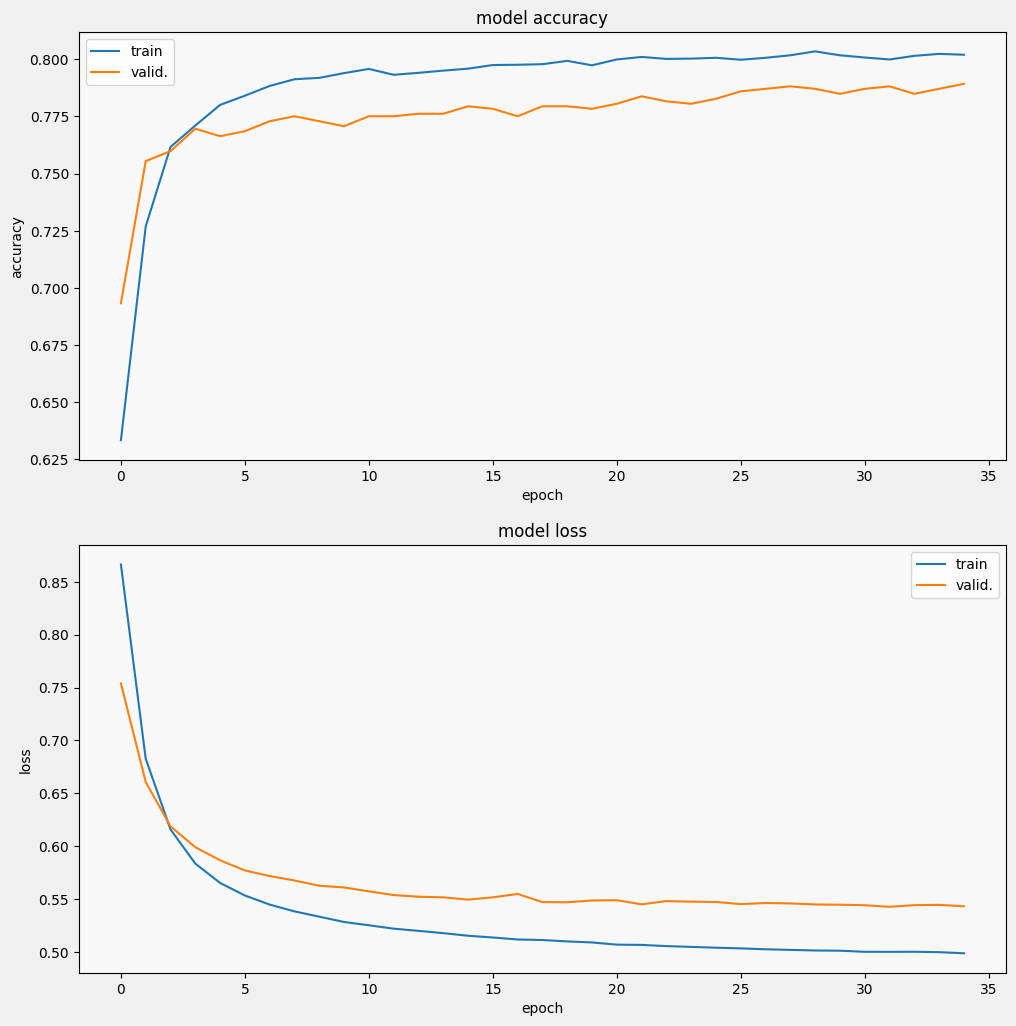

In [9]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

## 모델 평가하기

그리고 모델이 어떤 성능을 보이는지 알아보겠습니다. 손실(오류를 나타내는 숫자, 값이 낮을수록 좋음) 및 정확성의 두 가지 값이 반환됩니다.

In [10]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print('%s: %.3f' % (name, value))

4/4 - 0s - loss: 0.5347 - accuracy: 0.7907 - 265ms/epoch - 66ms/step


loss: 0.535
accuracy: 0.791


특히 정확성이 빠르게 증가하는 동안 손실이 빠르게 감소하는 것을 볼 수 있습니다. 예측이 실제 레이블과 어떻게 관련되는지 확인하기 위해 몇 가지 예를 플롯해 보겠습니다.

In [11]:
prediction_dataset = next(iter(test_data.batch(20)))

prediction_texts = [ex.numpy().decode('utf8') for ex in prediction_dataset[0]]
prediction_labels = [label2str(x) for x in prediction_dataset[1]]

predictions = [
    label2str(x) for x in np.argmax(model.predict(prediction_texts), axis=-1)]


pd.DataFrame({
    TEXT_FEATURE_NAME: prediction_texts,
    LABEL_NAME: prediction_labels,
    'prediction': predictions
})

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 153ms/step


string       label  prediction
0   The diffraction grating, LED, and split detect...  background      method
1   Our ideas are based on a previous paper [4] de...  background      method
2   Our finding is consistent with the literature ...      result      result
3   Test scores from each of the cognitive domains...      method      method
4   The optimization algorithm was set to maximize...      method      method
5   To quantify the extent of substitution saturat...      method      method
6   Examples of gesture control are based on the e...      method      method
7   The identification of these features has been ...      method  background
8   Postulated mechanisms for observed effects of ...  background  background
9   The right inferior phrenic artery is the most ...  background  background
10  [8] presented an approach for estimating the t...  background      method
11  Similar structures were observed in M10 cells ...      result      method
12  Cytotoxic effects of cobalt chloride were repo...  background      result
13  However, prolonged incubation of latex enzyme ...  background  background
14  …and travels great distances, resulting in a s...  background  background
15  The images fused using region selection; MSD, ...      method      method
16  These findings were expected, as EMG activity ...      result  background
17  The model has been extended to both 2D and 3D ...      method  background
18  Therefore, many authors claim comprehensive nu...  background      method
19  Similar to Ab40, IAPP-GI populates an aggregat...  background  background

이 무작위 샘플의 경우 모델이 대부분 올바른 레이블을 예측하여 과학적 문장을 상당히 잘 포함할 수 있음을 알 수 있습니다.

# 다음 단계

이제 TF-Hub의 CORD-19 Swivel 임베딩에 대해 조금 더 알게 되었으므로 CORD-19 Kaggle 대회에 참여하여 코로나바이러스감염증-19 관련 학술 텍스트에서 과학적 통찰력을 얻는 데 기여해 보세요.

- [CORD-19 Kaggle 챌린지](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge)에 참여하세요.
- [코로나바이러스감염증-19 공개 연구 데이터세트(CORD-19)](https://api.semanticscholar.org/CorpusID:216056360)에 대해 자세히 알아보세요.
- https://tfhub.dev/tensorflow/cord-19/swivel-128d/3에서 설명서를 참조하고 TF-Hub 임베딩에 대한 자세히 알아보세요.
- [TensorFlow 임베딩 프로젝터](http://projector.tensorflow.org/?config=https://storage.googleapis.com/tfhub-examples/tensorflow/cord-19/swivel-128d/3/tensorboard/projector_config.json)로 CORD-19 임베딩 공간을 탐색해 보세요.